# Starter Code : EDA

In [ ]:
import warnings
import itertools
import numpy as np 
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss

warnings.simplefilter(action='ignore')
sns.set_style('whitegrid')

## 1 - Loading the Data

In [ ]:
dtypes = {"crew": "int8",
          "experiment": "category",
          "time": "float32",
          "seat": "int8",
          "eeg_fp1": "float32",
          "eeg_f7": "float32",
          "eeg_f8": "float32",
          "eeg_t4": "float32",
          "eeg_t6": "float32",
          "eeg_t5": "float32",
          "eeg_t3": "float32",
          "eeg_fp2": "float32",
          "eeg_o1": "float32",
          "eeg_p3": "float32",
          "eeg_pz": "float32",
          "eeg_f3": "float32",
          "eeg_fz": "float32",
          "eeg_f4": "float32",
          "eeg_c4": "float32",
          "eeg_p4": "float32",
          "eeg_poz": "float32",
          "eeg_c3": "float32",
          "eeg_cz": "float32",
          "eeg_o2": "float32",
          "ecg": "float32",
          "r": "float32",
          "gsr": "float32",
          "event": "category",
         }

In [ ]:
train_df = pd.read_csv("../input/train.csv", dtype=dtypes)
test_df = pd.read_csv("../input/test.csv", dtype=dtypes)

In [ ]:
# train_df.info()

No missing values.

In [15]:
train_df.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,1,CA,0.011719,1,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,23.712299,-6.695870,29.232100,24.842899,3.92134,18.447001,1.07547,3.09029,37.368999,17.437599,19.201900,20.5968,-3.95115,14.507600,-4520.0,817.705994,388.829987,A
1,1,CA,0.015625,1,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,21.010300,-6.474720,26.641399,24.138800,5.46991,20.510599,2.83354,7.10177,31.170799,19.399700,19.689501,21.3547,1.33212,17.750200,-4520.0,817.705994,388.829987,A
2,1,CA,0.019531,1,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,25.431801,-0.088707,28.119900,26.891300,8.57886,23.162901,4.51993,12.70550,-12.012600,19.396299,23.171700,22.4076,1.53786,22.247000,-4520.0,817.705994,388.829987,A
3,1,CA,0.023438,1,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,19.142799,-0.256516,30.653601,24.247000,8.64310,19.961901,7.27575,11.45980,18.574100,23.156401,22.641199,19.3367,2.54492,18.998600,-4520.0,817.705994,388.829987,A
4,1,CA,0.027344,1,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,20.572100,-1.953470,31.722601,25.155500,12.50030,18.746901,7.30976,8.00805,6.555440,22.754700,22.670300,20.2932,1.69962,22.812799,-4520.0,817.705994,388.829987,A


In [ ]:
test_df.head()

## 2 - EDA

### Target & Experiment

The pilots experienced distractions intended to induce one of the following three cognitive states:

- Channelized Attention (CA) is, roughly speaking, the state of being focused on one task to the exclusion of all others. This is induced in benchmarking by having the subjects play an engaging puzzle-based video game.
- Diverted Attention (DA) is the state of having one’s attention diverted by actions or thought processes associated with a decision. This is induced by having the subjects perform a display monitoring task. Periodically, a math problem showed up which had to be solved before returning to the monitoring task.
- Startle/Surprise (SS) is induced by having the subjects watch movie clips with jump scares.

Samples are labelled the following way : 
- A = baseline
- B = SS
- C = CA
- D = DA

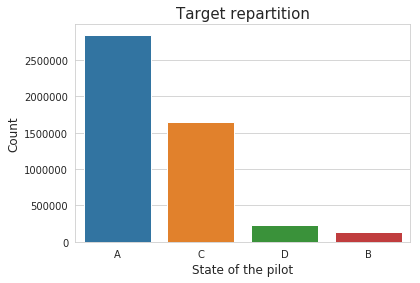

In [11]:
# plt.figure(figsize=(15,10))
sns.countplot(train_df['event'])
plt.xlabel("State of the pilot", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Target repartition", fontsize=15)
plt.show()

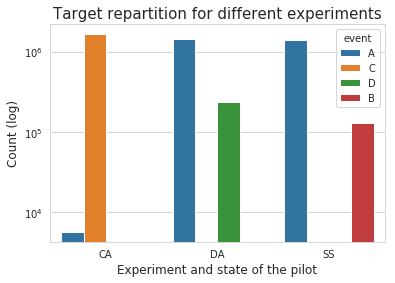

In [14]:
# plt.figure(figsize=(15,10))
sns.countplot('experiment', hue='event', data=train_df)
plt.xlabel("Experiment and state of the pilot", fontsize=12)
plt.ylabel("Count (log)", fontsize=12)
plt.yscale('log')
plt.title("Target repartition for different experiments", fontsize=15)
plt.show()

The experiment of the test set is LOFT (Line Oriented Flight Training), which is a full flight (take off, flight, and landing) in a flight simulator. 

### Seat
Which seat the pilot is sitting in.
- 0 : left seat
- 1 : right seat

This probably has nothing to do with the outcome of the experiment though.

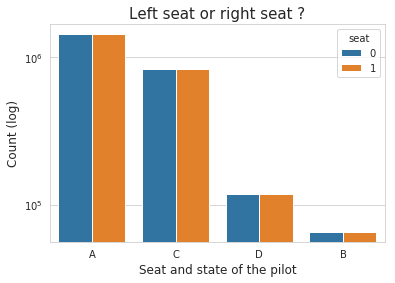

In [17]:
# plt.figure(figsize=(15,10))
sns.countplot('event', hue='seat', data=train_df)
plt.xlabel("Seat and state of the pilot", fontsize=12)
plt.ylabel("Count (log)", fontsize=12)
plt.yscale('log')
plt.title("Left seat or right seat ?", fontsize=15)
plt.show()

### Time of the experiment

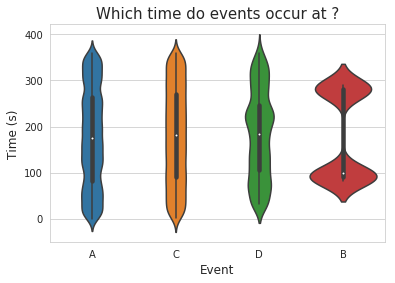

In [21]:
# plt.figure(figsize=(15,10))
sns.violinplot(x='event', y='time', data=train_df.sample(50000))
plt.ylabel("Time (s)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title("Which time do events occur at ?", fontsize=15)
plt.show()

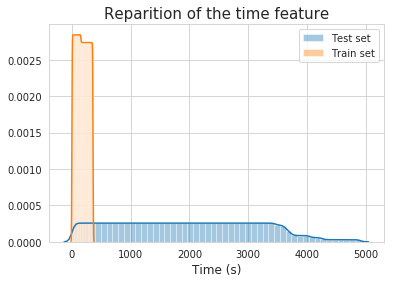

In [26]:
# plt.figure(figsize=(15,10))
sns.distplot(test_df['time'], label='Test set')
sns.distplot(train_df['time'], label='Train set')
plt.legend()
plt.xlabel("Time (s)", fontsize=12)
plt.title("Reparition of the time feature", fontsize=15)
plt.show()

The repartition of events is interesting. However, we can't use this feature because time in the flight simulator has nothing to do with time in the experiments. 
It's a shame because take-off and landing could have been exploited.

### Electroencephalogram recordings

In [27]:
eeg_features = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2"]

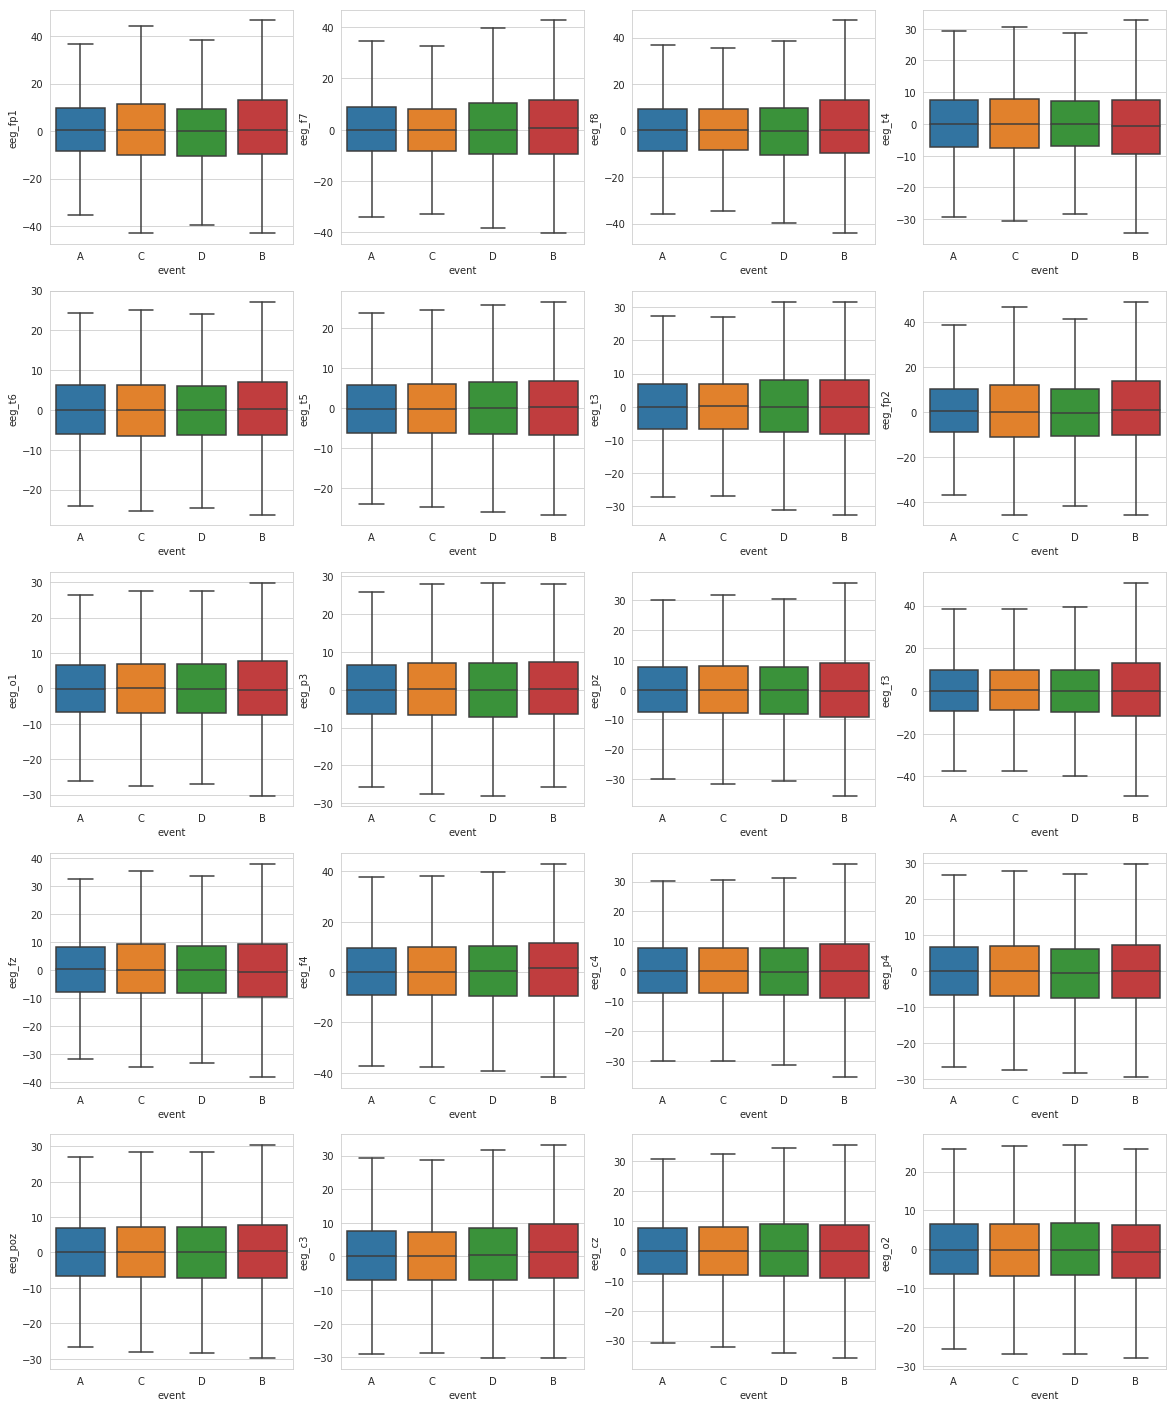

In [30]:
plt.figure(figsize=(20,25))
i = 0

for egg in eeg_features:
    i += 1
    plt.subplot(5, 4, i)
    sns.boxplot(x='event', y=egg, data=train_df.sample(50000), showfliers=False)

plt.show()

We Also check if features have the same distribution on the test and train set

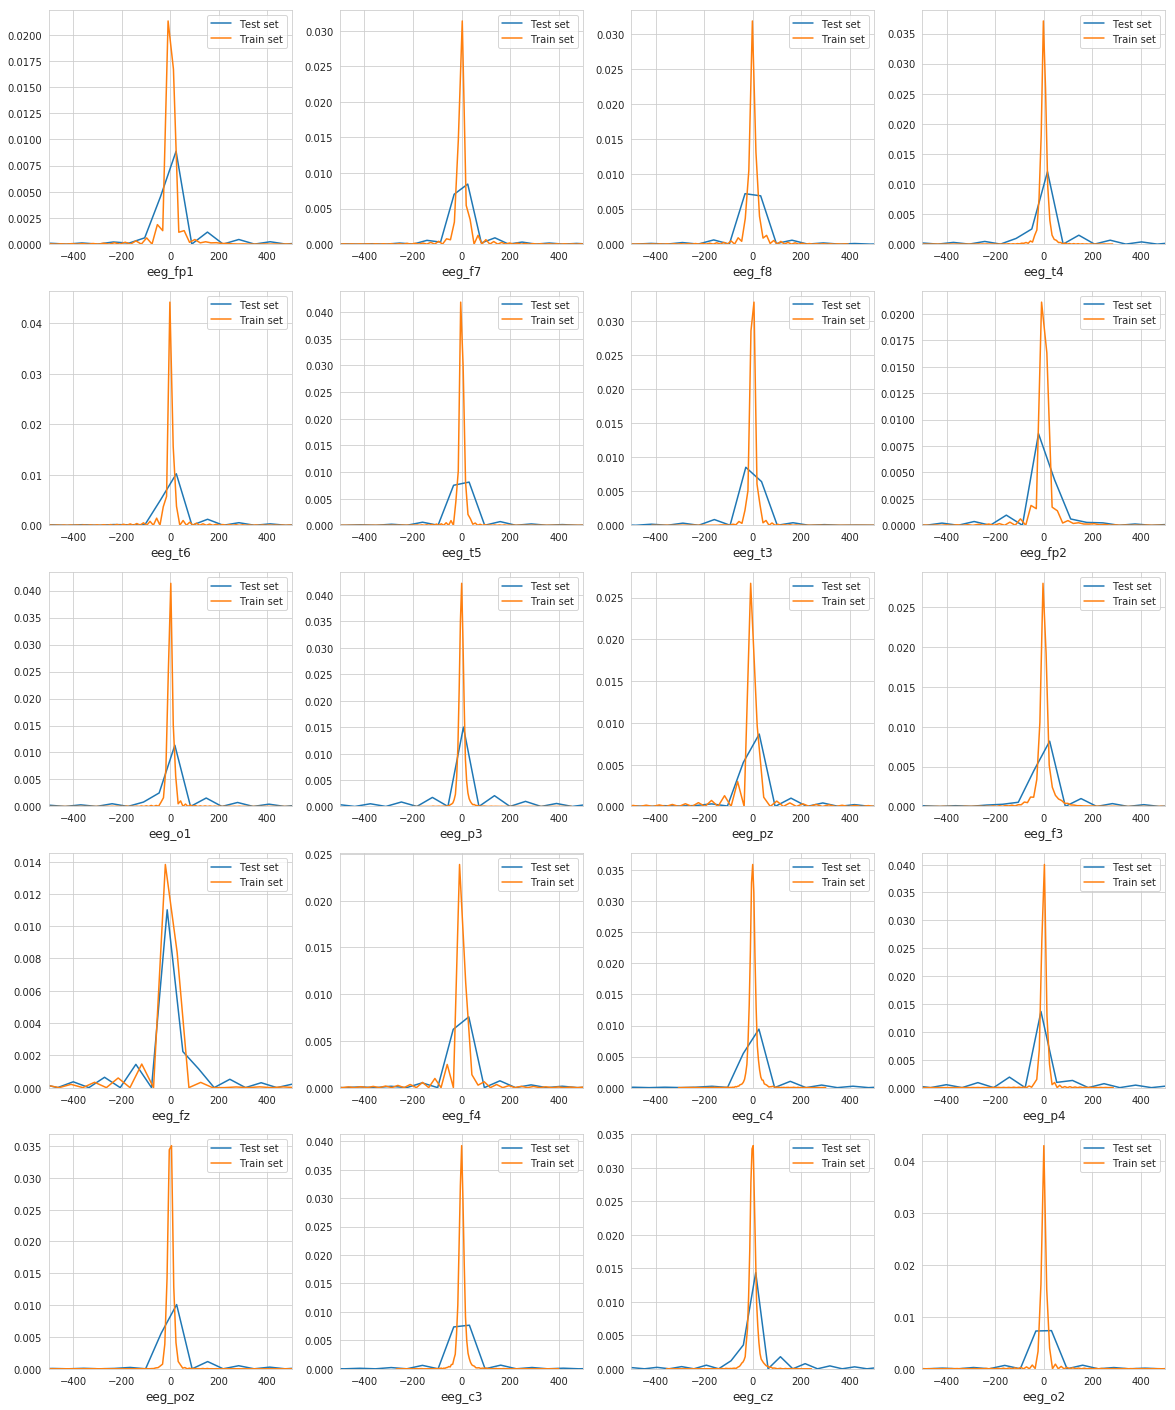

In [31]:
plt.figure(figsize=(20,25))
plt.title('Eeg features distributions')
i = 0

for eeg in eeg_features:
    i += 1
    plt.subplot(5, 4, i)
    sns.distplot(test_df.sample(10000)[eeg], label='Test set', hist=False)
    sns.distplot(train_df.sample(10000)[eeg], label='Train set', hist=False)
    plt.xlim((-500, 500))
    plt.legend()
    plt.xlabel(eeg, fontsize=12)

plt.show()

Reparitions seem consistent :  Gaussians with a sinusoïdal noise centered at 0. Note that the variance is larger on the test set.

### Electrocardiogram
- 3-point Electrocardiogram signal. The sensor had a resolution/bit of .012215 µV and a range of -100mV to +100mV. The data are provided in microvolts.

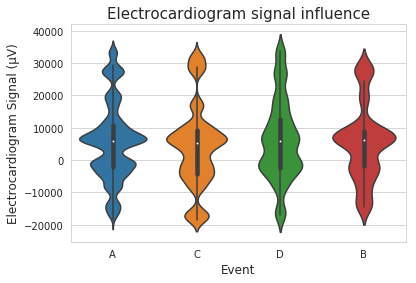

In [32]:
# plt.figure(figsize=(15,10))
sns.violinplot(x='event', y='ecg', data=train_df.sample(50000))
plt.ylabel("Electrocardiogram Signal (µV)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title("Electrocardiogram signal influence", fontsize=15)
plt.show()

In [36]:
train_df["ecg"].min()

-18585.7

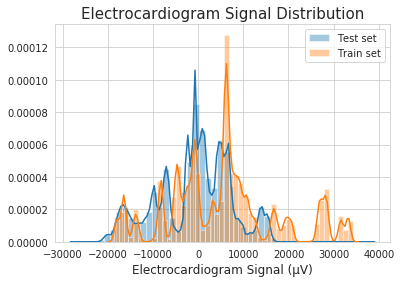

In [33]:
# plot the distribution of the ecg singals
# plt.figure(figsize=(15,10))
sns.distplot(test_df['ecg'], label='Test set')
sns.distplot(train_df['ecg'], label='Train set')
plt.legend()
plt.xlabel("Electrocardiogram Signal (µV)", fontsize=12)
plt.title("Electrocardiogram Signal Distribution", fontsize=15)
plt.show()

Except foir the >20000-ish samples, train/test repartitions are similar.

### Respiration 
- A measure of the rise and fall of the chest. The sensor had a resolution/bit of .2384186 µV and a range of -2.0V to +2.0V. The data are provided in microvolts.

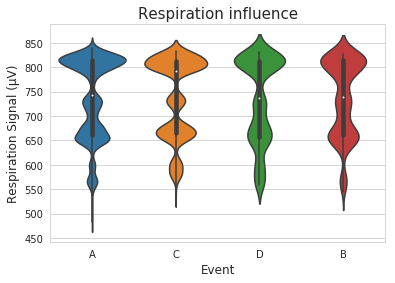

In [37]:
# plt.figure(figsize=(15,10))
sns.violinplot(x='event', y='r', data=train_df.sample(50000))
plt.ylabel("Respiration Signal (µV)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title("Respiration influence", fontsize=15)
plt.show()

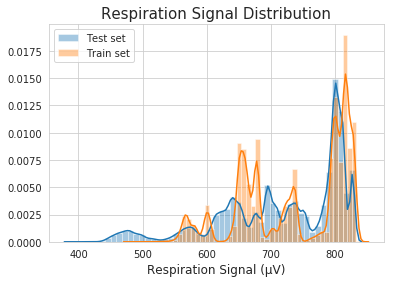

In [39]:
# plt.figure(figsize=(15,10))
sns.distplot(test_df['r'], label='Test set')
sns.distplot(train_df['r'], label='Train set')
plt.legend()
plt.xlabel("Respiration Signal (µV)", fontsize=12)
plt.title("Respiration Signal Distribution", fontsize=15)
plt.show()

Nothing much to say here, the test set has a bunch of sample with lower values though.

### Galvanic Skin Response
 - A measure of electrodermal activity. The sensor had a resolution/bit of .2384186 µV and a range of -2.0V to +2.0V. The data are provided in microvolts.
 > "The galvanic skin response (GSR, which falls under the umbrella term of electrodermal activity, or EDA) refers to changes in sweat gland activity that are reflective of the intensity of our emotional state, otherwise known as emotional arousal."

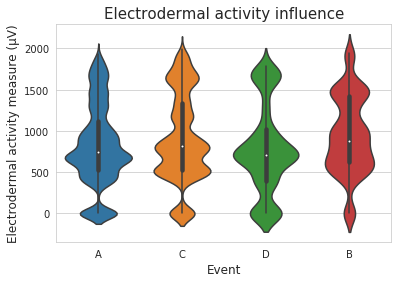

In [41]:
# plt.figure(figsize=(15,10))
sns.violinplot(x='event', y='gsr', data=train_df.sample(50000))
plt.ylabel("Electrodermal activity measure (µV)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title("Electrodermal activity influence", fontsize=15)
plt.show()

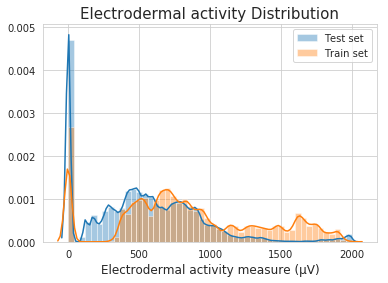

In [42]:
# plt.figure(figsize=(15,10))
sns.distplot(test_df['gsr'], label='Test set')
sns.distplot(train_df['gsr'], label='Train set')
plt.legend()
plt.xlabel("Electrodermal activity measure (µV)", fontsize=12)
plt.title("Electrodermal activity Distribution", fontsize=15)
plt.show()

Again, quite similar.

This is quite similiar. 

## 3 - Gradient Boosting

### Normalizing 

Because of earlier remarks, we normalize our features. 

I do believe the following features depend a lot of the person, therefore I apply a Min/Max Scaler for each pilot.

In [ ]:
features_n = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2", "ecg", "r", "gsr"]

In [ ]:
train_df['pilot'] = 100 * train_df['seat'] + train_df['crew']
test_df['pilot'] = 100 * test_df['seat'] + test_df['crew']

print("Number of pilots : ", len(train_df['pilot'].unique()))

In [ ]:
def normalize_by_pilots(df):
    pilots = df["pilot"].unique()
    for pilot in tqdm(pilots):
        ids = df[df["pilot"] == pilot].index
        scaler = MinMaxScaler()
        df.loc[ids, features_n] = scaler.fit_transform(df.loc[ids, features_n])
        
    return df

In [ ]:
train_df = normalize_by_pilots(train_df)
test_df = normalize_by_pilots(test_df)

### Train / Test split

In [ ]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=420)
print(f"Training on {train_df.shape[0]} samples.")

### Model
Note that I did not bother tweaking the parameters yet.

In [ ]:
features = ["crew", "seat"] + features_n
      
def run_lgb(df_train, df_test):
    # Classes as integers
    dic = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
    try:
        df_train["event"] = df_train["event"].apply(lambda x: dic[x])
        df_test["event"] = df_test["event"].apply(lambda x: dic[x])
    except: 
        pass
    
    params = {"objective" : "multiclass",
              "num_class": 4,
              "metric" : "multi_error",
              "num_leaves" : 30,
              "min_child_weight" : 50,
              "learning_rate" : 0.1,
              "bagging_fraction" : 0.7,
              "feature_fraction" : 0.7,
              "bagging_seed" : 420,
              "verbosity" : -1
             }
    
    lg_train = lgb.Dataset(df_train[features], label=(df_train["event"]))
    lg_test = lgb.Dataset(df_test[features], label=(df_test["event"]))
    model = lgb.train(params, lg_train, 1000, valid_sets=[lg_test], early_stopping_rounds=50, verbose_eval=100)
    
    return model

In [ ]:
model = run_lgb(train_df, val_df)

### Feature importance

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, height=0.8, ax=ax)
ax.grid(False)
plt.ylabel('Feature', size=12)
plt.xlabel('Importance', size=12)
plt.title("Importance of the Features of our LightGBM Model", fontsize=15)
plt.show()

### Confusion Matrix

In [ ]:
pred_val = model.predict(val_df[features], num_iteration=model.best_iteration)
#pred_train = model.predict(train_df[features], num_iteration=model.best_iteration)

In [ ]:
print("Log loss on validation data :", round(log_loss(np.array(val_df["event"].values), pred_val), 3))

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fmt = '.2f' if normalize else 'd'

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=15)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = (cm.max()+cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size=12)
    plt.xlabel('Predicted label', size=12)

In [ ]:
conf_mat_val = confusion_matrix(np.argmax(pred_val, axis=1), val_df["event"].values)
plot_confusion_matrix(conf_mat_val, ["A", "B", "C", "D"], title='Confusion matrix on Validation data', normalize=True)

### Submission

In [ ]:
pred_test = model.predict(test_df[features], num_iteration=model.best_iteration)

In [ ]:
submission = pd.DataFrame(np.concatenate((np.arange(len(test_df))[:, np.newaxis], pred_test), axis=1), columns=['id', 'A', 'B', 'C', 'D'])
submission['id'] = submission['id'].astype(int)

In [ ]:
submission.head()

In [ ]:
submission.to_csv("submission.csv", index=False)

Any feedback is always appreciated ! 

### *Thanks for reading !*
